# Notebook de test

Ce notebook contient toutes les modélisations supervisées et non supervisées du projet, ainsi que différentes méthodes de sencente embedding.

# Imports

In [ ]:
# Connecte le notebook Colab à Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Librairies

In [ ]:
!pip install pyldavis

# Import de librairies
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import missingno as msno

from bs4 import BeautifulSoup
from bs4 import UnicodeDammit

from yellowbrick.text import FreqDistVisualizer

import pyLDAvis
import pyLDAvis.sklearn

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, hamming_loss, jaccard_score

from sklearn.pipeline import Pipeline

!pip install --upgrade gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 6.8 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyldavis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=e400e2383e5b89f7ce44ebe2296d306af25c67e15b7b406df5e0a16d27890c12
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyldavis


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.1 MB 48.3 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


## Données

In [ ]:
# Charge le dataset traité
df = pd.read_csv('drive/MyDrive/PStackOverflow/data/df_clean.csv')
df.shape

(53750, 12)

# Selection des tags les plus communs

In [ ]:
# compte le nombre d'occurence de chaque tag
vectorizer = CountVectorizer(token_pattern="[\S]+")  ### r"\b\S+\b"
docs = vectorizer.fit_transform(df["cleaned_Tags"])

# recupère tous les tags dans une liste
features = vectorizer.get_feature_names()

<input>:2: DeprecationWarning: invalid escape sequence \S
<input>:2: DeprecationWarning: invalid escape sequence \S
<input>:2: DeprecationWarning: invalid escape sequence \S
<input>:2: DeprecationWarning: invalid escape sequence \S
<input>:2: DeprecationWarning: invalid escape sequence \S
<ipython-input-4-89959313f954>:2: DeprecationWarning: invalid escape sequence \S
  vectorizer = CountVectorizer(token_pattern="[\S]+")  ### r"\b\S+\b"
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


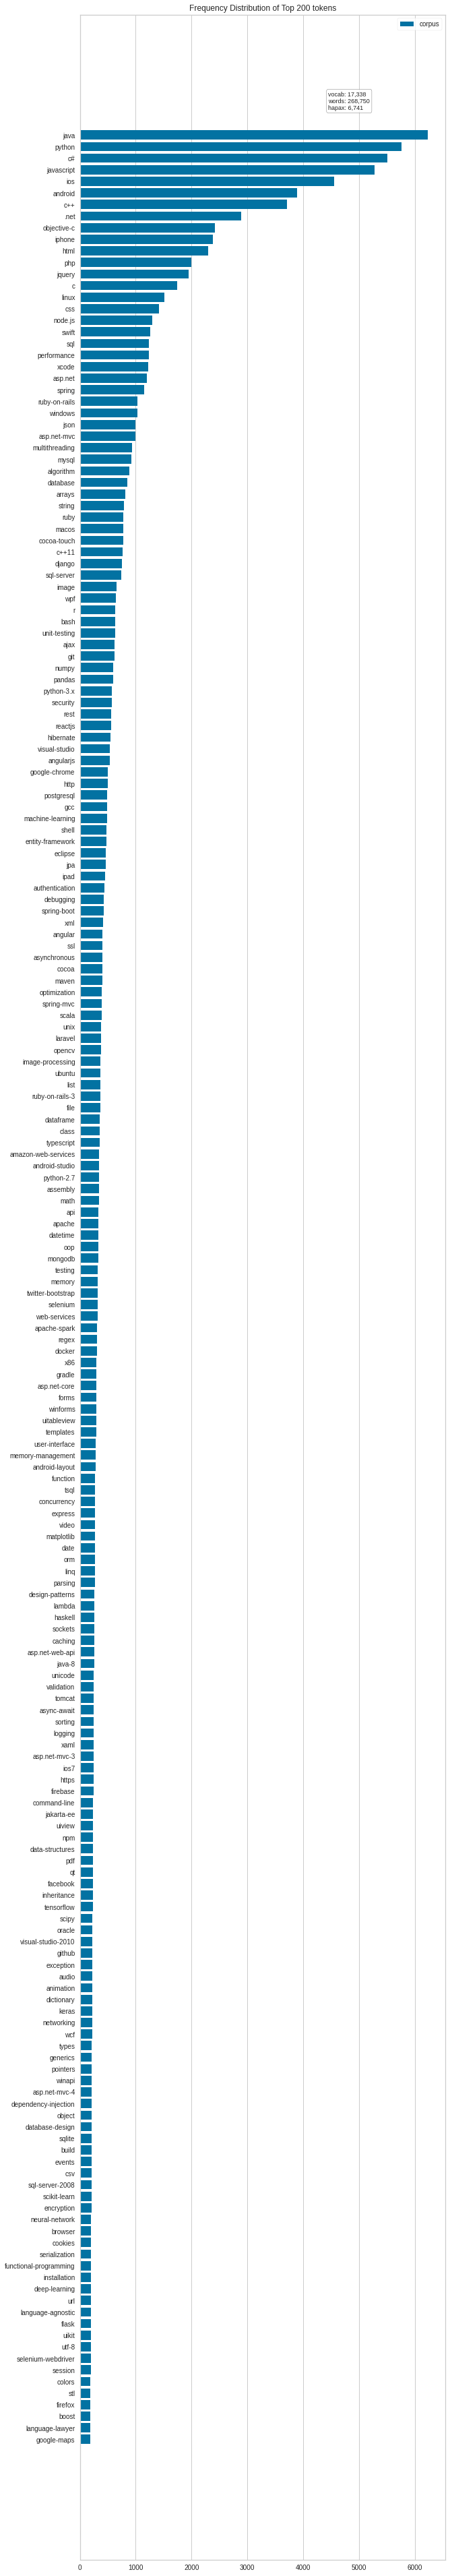

In [ ]:
# barchart des tags par occurence
visualizer = FreqDistVisualizer(features=features, n=200, orient='h', size=(700, 5000))
visualizer.fit(docs)
visualizer.show()

Je choisi (arbitrairement) de limiter le nombre des tags à prédire à 50:
- la fréquence diminue de manière ~linéaire après les ~15 tags les plus communs
- le 50em tags le plus commun couvre ~2% du dataset
- la grande majorité des ~53000 observations ont au moins un tag, ~10% (~6000) du data set n'a pas de tags

In [ ]:
# nombre d'occurence de chaque tag
tag_occurences = visualizer.count(docs)

In [ ]:
# DataFrame des tags et leur occurence respective
d = {'Tag': features, 'count': tag_occurences}
tag_df = pd.DataFrame(data=d)

In [ ]:
# Order le DataFrame par nombre d'occurence décroissant
tag_df = tag_df.sort_values(by=['count'], ascending=False)

# Check
tag_df

,Tag,count
7710,java,6235
11976,python,5760
2194,c#,5510
7777,javascript,5282
7478,ios,4559
...,...,...
8473,least-common-ancestor,1
8474,least-privilege,1
8478,leftalign,1
8480,legacy-app,1


In [ ]:
# Check
tag_df.Tag

7710                      java
11976                   python
2194                        c#
7777                javascript
7478                       ios
                 ...          
8473     least-common-ancestor
8474           least-privilege
8478                 leftalign
8480                legacy-app
17337                     zynq
Name: Tag, Length: 17338, dtype: object

In [ ]:
# Nombre de tags les plus communs à retenir
n_tags = 50

# liste des n tags les plus communs
feature_list = list(tag_df['Tag'].head(n_tags))

# set
feature_set = set(feature_list)

In [ ]:
# Retire les tags les moins communs
def tag_cleaner(tags):

  splitted_tags = tags.split()

  intersection = feature_set.intersection(splitted_tags)


  common_tags = ' '.join(intersection)

  return common_tags

In [ ]:
# Check
df.cleaned_Tags

0             c file directory cross-platform common-tasks
1                       c# .net wcf web-services datatable
2              .net class struct value-type reference-type
3                php mysql pdo mysqli database-abstraction
4        javascript date datetime timezone timezone-offset
                               ...                        
53745                             c++ cmake clang llvm lto
53746      express reactjs webpack react-router production
53747             r performance dplyr magrittr cardinality
53748      python c++ python-3.x rounding integer-division
53749    android android-gradle-plugin android-architec...
Name: cleaned_Tags, Length: 53750, dtype: object

In [ ]:
# enlève les tags les moins communs
df['common_Tags'] = df['cleaned_Tags'].apply(tag_cleaner)
df['common_Tags']

0                            c
1                      c# .net
2                         .net
3                    php mysql
4                   javascript
                 ...          
53745                      c++
53746                         
53747            performance r
53748    python-3.x c++ python
53749                  android
Name: common_Tags, Length: 53750, dtype: object

In [ ]:
df.common_Tags[df['common_Tags'] == '']

12        
24        
37        
39        
45        
        ..
53720     
53726     
53731     
53742     
53746     
Name: common_Tags, Length: 6198, dtype: object

In [ ]:
# transforme la string des tags en liste
df['list_common_Tags'] = df['common_Tags'].str.split()
df['list_common_Tags']

0                              [c]
1                       [c#, .net]
2                           [.net]
3                     [php, mysql]
4                     [javascript]
                   ...            
53745                        [c++]
53746                           []
53747             [performance, r]
53748    [python-3.x, c++, python]
53749                    [android]
Name: list_common_Tags, Length: 53750, dtype: object

In [ ]:
# garde uniquement les observations ayant un tag ou plus
df_cleaned = df
df_cleaned = df_cleaned.reset_index(drop=True)
df_cleaned.shape

(53750, 14)

In [ ]:
# Check
df_cleaned['list_common_Tags']

0                              [c]
1                       [c#, .net]
2                           [.net]
3                     [php, mysql]
4                     [javascript]
                   ...            
53745                        [c++]
53746                           []
53747             [performance, r]
53748    [python-3.x, c++, python]
53749                    [android]
Name: list_common_Tags, Length: 53750, dtype: object

# Vectorizaton des labels (tags)

https://www.kaggle.com/questions-and-answers/66693

In [ ]:
# Vectorization des tags dans un format exploitable par sklearn
mlb = MultiLabelBinarizer()
mlb.fit(df_cleaned['list_common_Tags'])

# attribue les tags vectorisés
mlb_tags = mlb.transform(df_cleaned['list_common_Tags'])

# Check
mlb_tags.shape

(53750, 50)

In [ ]:
# Check
mlb_tags

array([[0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
# Shape
mlb_tags.shape

(53750, 50)

In [ ]:
# Nombre de classes
len(mlb.classes_)

50

# LDA: Apprentissage Non Supervisé

## SKlearn: entrainement de la LDA

### Train_test_split sur subset

Le temps de calcul d'une LDA étant long, d'autant plus que pour déterminer le nombre de topics maximisant la log likelihood une gridsearch et donc plusieurs entrainements sont nécessaires: je choisi de limiter la taille de l'échantillon.

-> 10000 observations, dont 1/3 pour le test set.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_cleaned.head(10000).cleaned_Text, mlb_tags[:10000], test_size=0.33, random_state=42)

### CountVectorizer

In [ ]:
vectorizer = CountVectorizer()

texts = vectorizer.fit_transform(X_train)
texts_test = vectorizer.transform(X_test)

### Definition du nombre topics

In [ ]:
# Gridsearch
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit

lda = LatentDirichletAllocation(n_jobs=-1, random_state=42)

params = {'n_components' : [8, 10, 12]}

gridsearch_lda = GridSearchCV(lda,
                              param_grid=params,
                              verbose=3,
                              cv=2)

gridsearch_lda.fit(texts)

Fitting 2 folds for each of 3 candidates, totalling 6 fits
[CV 1/2] END .............n_components=8;, score=-1802384.662 total time=  30.7s
[CV 2/2] END .............n_components=8;, score=-1841559.610 total time=  22.4s
[CV 1/2] END ............n_components=10;, score=-1831316.117 total time=  14.7s
[CV 2/2] END ............n_components=10;, score=-1871519.893 total time=  14.8s
[CV 1/2] END ............n_components=12;, score=-1863698.143 total time=  14.7s
[CV 2/2] END ............n_components=12;, score=-1899927.784 total time=  14.6s


GridSearchCV(cv=2,
             estimator=LatentDirichletAllocation(n_jobs=-1, random_state=42),
             param_grid={'n_components': [8, 10, 12]}, verbose=3)

In [ ]:
# Modèle avec n topics maximisant le score Log Likelihood
lda_model = gridsearch_lda.best_estimator_

In [ ]:
print("Meilleurs paramètres: ", gridsearch_lda.best_params_)
print("Meilleur score Log Likelihood: ", gridsearch_lda.best_score_)

Meilleurs paramètres:  {'n_components': 8}
Meilleur score Log Likelihood:  -1821972.1356359427


## pyLDAvis: Visualisation des topics

In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_model, texts, vectorizer, mds='tsne')
panel

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distan

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
1     -108.958252 -208.941483       1        1  17.600385
5      186.487061  -98.103249       2        1  15.528580
3       19.245832  160.858780       3        1  13.699724
7      170.658829   75.445076       4        1  12.515373
6       -1.386411  -35.043739       5        1  11.686556
4     -145.800095  106.944611       6        1  10.612329
2       64.834541 -221.825272       7        1   9.667867
0     -196.906036  -58.990913       8        1   8.689186, topic_info=           Term         Freq        Total Category  logprob  loglift
7233       file  2796.000000  2796.000000  Default  30.0000  30.0000
9686      image  1180.000000  1180.000000  Default  29.0000  29.0000
14641      page   953.000000   953.000000  Default  28.0000  28.0000
19874     table   716.000000   716.000000  Default  27.0000  27.0000
4828   database   847.000000   847.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
13382      need   190.711555  2104.548881   Topic8  -5.2883   0.0420
8342       good   166.247441  1214.248628   Topic8  -5.4256   0.4547
8119        get   185.087134  3373.401169   Topic8  -5.3183  -0.4598
20374      time   162.332141  1500.365771   Topic8  -5.4495   0.2193
21739     value   157.001544  1155.907600   Topic8  -5.4828   0.4467

[667 rows x 6 columns], token_table=       Topic      Freq           Term
term                                 
86         2  0.946168  accelerometer
99         1  0.068518         access
99         2  0.072987         access
99         3  0.600281         access
99         4  0.162359         access
...      ...       ...            ...
22868      8  0.017842            xml
22927      5  0.947295          xunit
22946      2  0.927645             xy
22962      2  0.934506            yaw
23070      2  0.963661           zone

[1872 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 6, 4, 8, 7, 5, 3, 1])

Bien qu'ayant des connaissances limitées de ces sujets, les topics de la LDA semblent avoir les themes suivant au regard de leurs "Top-30 Most Relevant Terms":

- 1: Système d'exploitation, bash/shell, (windows et linux/android)
- 2: algorithmes, classes et Programmation Orientée Objets
- 3: API
- 4: strings/textes
- 5: Java
- 6: JavaScript et développement web
- 7: développement mobile (Apple/iOs)
- 8: SQL et bases de données



In [ ]:
# prob des topics du test set
topics_train_set = lda_model.transform(texts)

In [ ]:
# Exemple d'une observation du topic 8 (SQL et BDD)
df_cleaned.cleaned_Text[1]

'return datatable wcf neti wcf service want return datatable know often highly debate topic far whether return datatable good practice let us put aside moment create datatable scratch problem whatsoever table create populate return client well however soon go hit database create table get communicationexception underlie connection close connection close unexpectedly table populate correctly server side significantly small test table loop return query small fast issue timeout large datum transfer exact function datacontract servicecontract behaviorcontract use would way table populate bearing table return successfully'

In [ ]:
print(df["Body"][1])

<p>I have a WCF service from which I want to return a DataTable. I know that this is often a highly-debated topic, as far as whether or not returning DataTables is a good practice. Let's put that aside for a moment.</p>

<p>When I create a DataTable from scratch, as below, there are no problems whatsoever. The table is created, populated, and returned to the client, and all is well:</p>

<pre><code>[DataContract]
public DataTable GetTbl()
{
    DataTable tbl = new DataTable("testTbl");
    for(int i=0;i&lt;100;i++)
    {
        tbl.Columns.Add(i);
        tbl.Rows.Add(new string[]{"testValue"});
    }
    return tbl;
}
</code></pre>

<p>However, as soon as I go out and hit the database to create the table, as below, I get a CommunicationException "The underlying connection was closed: The connection was closed unexpectedly."</p>

<pre><code>[DataContract]
public DataTable GetTbl()
{
    DataTable tbl = new DataTable("testTbl");
    //Populate table with SQL query

    return tbl;
}
</

In [ ]:
df.cleaned_Tags[1]

'c# .net wcf web-services datatable'

In [ ]:
# Probabilités par topic
lda_model.transform(
    vectorizer.transform([df_cleaned.cleaned_Text[1]])
)


array([[0.48708136, 0.00147223, 0.00147223, 0.50407672, 0.00147547,
        0.0014736 , 0.00147371, 0.00147468]])

## Gensim LDA: obtention du coherence score 

Utiliser Gensim étant la seule manière d'obtenir le Coherence Score pour la LDA, il est necessaire de la réentrainer avec cette librairie en utilisant les mêmes hyperparamètres.

In [ ]:
# Definition du dictionaire
from gensim.corpora.dictionary import Dictionary

dataset = [d.split() for d in X_train]
common_dictionary = Dictionary(dataset)
corpus = [common_dictionary.doc2bow(text) for text in dataset]

/usr/local/lib/python3.7/dist-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [ ]:
from gensim.models.ldamulticore import LdaMulticore

# Build LDA model
lda_gensim = LdaMulticore(corpus=corpus,
                            id2word=common_dictionary,
                            num_topics=8, 
                            random_state=42)

In [ ]:
from gensim.models import CoherenceModel

# Compute Coherence Score
cm_lda = CoherenceModel(model=lda_gensim, texts=dataset, corpus=corpus, coherence='c_v')
coherence_lda = cm_lda.get_coherence()


print("Coherence Model - LDA: ", coherence_lda)

Coherence Model - LDA:  0.31660799608139767


## Matrices des mots clés sur les train et test sets

In [ ]:
M_questions_topics_train = lda_model.transform(texts)
M_questions_topics_train.shape

(6700, 8)

In [ ]:
M_questions_topics_test = lda_model.transform(texts_test)
M_questions_topics_test.shape

(3300, 8)

In [ ]:
M_topics_words = lda_model.components_
M_topics_words.shape

(8, 23090)

In [ ]:
M_proba_questions_words_train = np.matmul(M_questions_topics_train, M_topics_words)
M_proba_questions_words_train.shape

(6700, 23090)

In [ ]:
M_proba_questions_words_test = np.matmul(M_questions_topics_test, M_topics_words)
M_proba_questions_words_test.shape

(3300, 23090)

In [ ]:
# Passe les probas < 0.5 à 0
M_proba_questions_words_test[M_proba_questions_words_test < 0.5] = 0
M_proba_questions_words_test

array([[0.57594997, 0.        , 0.        , ..., 0.64261338, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
M_proba_questions_words_test.shape

(3300, 23090)

In [ ]:
df_proba_questions_words_test = pd.DataFrame(M_proba_questions_words_test, columns = vectorizer.get_feature_names_out())
df_proba_questions_words_test

,__init,__intercept,__invoke,__tools,_b,_block_invoke_,_dispatch,_handlerequest,_id,_mypath,...,zoomlevel,zoomout,zoomscaletozoomlevel,zulu,zuul,zuulapi,zxe,zxingi,zxy,zyx
0,0.57595,0.000000,0.00000,0.642613,0.0000,0.642464,0.000000,0.00000,0.000000,0.642613,...,0.000000,0.57951,0.000000,0.000000,0.000000,0.000000,0.642613,0.642613,0.000000,0.000000
1,0.00000,0.000000,0.00000,0.000000,0.0000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.511960,0.00000,0.000000,0.000000,1.873496,0.707832,0.000000,0.000000,0.000000,0.000000
2,0.00000,0.000000,0.00000,0.000000,0.0000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.976086,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.00000,0.000000,0.00000,1.096725,0.0000,1.096444,0.000000,0.00000,0.000000,1.096725,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.096725,1.096725,0.000000,0.000000
4,0.00000,0.000000,0.00000,0.694467,0.0000,0.694302,0.000000,0.00000,0.000000,0.694467,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.694467,0.694467,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3295,0.00000,0.000000,0.00000,0.000000,0.0000,0.000000,0.000000,0.00000,0.592953,0.000000,...,0.594511,0.00000,0.593039,1.529423,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3296,0.00000,0.709545,1.29411,0.000000,0.7094,0.000000,0.709545,1.29411,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.505535,0.000000,0.000000,0.000000,0.000000,1.878638,0.709499
3297,0.00000,0.000000,0.00000,0.000000,0.0000,0.000000,0.000000,0.00000,0.504007,0.000000,...,0.000000,0.00000,0.504051,1.262403,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3298,0.00000,0.000000,0.00000,0.000000,0.0000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,1.909300,0.719767,0.000000,0.000000,0.000000,0.000000


In [ ]:
df_proba_questions_words_test.shape

(3300, 23090)

In [ ]:
# Drop les mots n'étant pas dans les tags retenus
df_proba_questions_words_test.drop(
    columns=[col for col in df_proba_questions_words_test if col not in feature_list], 
    inplace=True
    )

df_proba_questions_words_test

,ajax,algorithm,android,arrays,bash,css,database,django,git,html,...,python,ruby,security,spring,sql,string,swift,windows,wpf,xcode
0,75.262412,1.669578,221.041537,0.000000,39.144003,104.984656,12.284071,1.526092,90.436539,278.157702,...,177.151426,22.249297,4.315910,2.122842,2.707696,9.214525,26.722471,107.814682,5.846264,160.276887
1,20.797801,9.808558,100.253607,0.000000,1.346552,1.467508,97.951386,100.208098,1.272780,12.306590,...,58.484338,23.494561,111.778147,177.940416,8.009034,7.223120,1.820435,18.873279,1.679803,1.846200
2,2.338862,90.872673,10.711412,6.160594,11.463977,1.119909,20.821046,12.709963,0.972339,6.630509,...,151.904923,14.895684,14.291199,110.729343,3.340034,328.786353,27.632191,11.713226,9.610809,1.401607
3,0.928784,1.430089,373.162122,0.000000,73.222591,1.174855,10.817210,1.882669,169.454561,23.522955,...,323.348108,41.229544,6.538847,1.866775,2.598257,12.500478,49.625674,195.676622,3.933149,300.618207
4,37.468848,3.648770,241.636947,0.000000,43.059591,48.607880,22.089284,14.641068,99.383072,137.018690,...,201.390136,28.223443,19.920643,51.407134,2.571184,7.790862,29.280016,119.423858,4.062172,176.230023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3295,0.623005,146.826430,2.812330,6.746504,0.000000,0.922607,52.298620,7.952978,2.845432,3.506046,...,139.170991,10.935785,6.303761,164.381584,26.352717,91.692048,31.605898,5.694524,15.212339,1.003333
3296,29.192235,38.050681,102.837370,1.932483,0.000000,41.148464,77.060004,2.470857,5.169328,105.113131,...,35.470843,3.603115,0.739521,2.180182,52.252481,28.241903,8.793965,8.074366,78.583792,21.272190
3297,0.000000,115.708271,57.054797,6.546096,16.280925,0.553386,84.795444,6.361004,28.818942,6.235786,...,182.615539,16.953678,4.206691,61.770220,52.321249,219.578116,36.803232,33.348445,14.850913,43.520199
3298,38.056682,5.306278,117.503886,0.000000,1.060685,25.002980,96.373813,102.091544,0.634825,71.900212,...,51.303684,21.483672,111.872721,117.664023,6.339987,4.425228,1.442330,18.208232,11.275644,3.511213


In [ ]:
df_proba_questions_words_test.shape

(3300, 35)

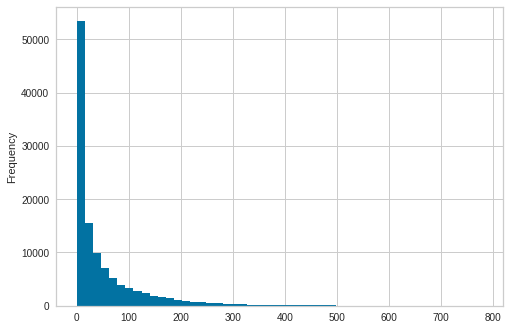

In [ ]:
df_proba_questions_words_test.stack().plot.hist(bins=50)

Seulement 35 des 50 tags les plus communs apparaissent en sortie de LDA prédictive.

In [ ]:
for col in feature_list:
    if col not in df_proba_questions_words_test.columns:
        df_proba_questions_words_test[col] = 0

df_proba_questions_words_test

,ajax,algorithm,android,arrays,bash,css,database,django,git,html,...,node.js,asp.net,ruby-on-rails,asp.net-mvc,cocoa-touch,c++11,sql-server,r,unit-testing,python-3.x
0,75.262412,1.669578,221.041537,0.000000,39.144003,104.984656,12.284071,1.526092,90.436539,278.157702,...,0,0,0,0,0,0,0,0,0,0
1,20.797801,9.808558,100.253607,0.000000,1.346552,1.467508,97.951386,100.208098,1.272780,12.306590,...,0,0,0,0,0,0,0,0,0,0
2,2.338862,90.872673,10.711412,6.160594,11.463977,1.119909,20.821046,12.709963,0.972339,6.630509,...,0,0,0,0,0,0,0,0,0,0
3,0.928784,1.430089,373.162122,0.000000,73.222591,1.174855,10.817210,1.882669,169.454561,23.522955,...,0,0,0,0,0,0,0,0,0,0
4,37.468848,3.648770,241.636947,0.000000,43.059591,48.607880,22.089284,14.641068,99.383072,137.018690,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3295,0.623005,146.826430,2.812330,6.746504,0.000000,0.922607,52.298620,7.952978,2.845432,3.506046,...,0,0,0,0,0,0,0,0,0,0
3296,29.192235,38.050681,102.837370,1.932483,0.000000,41.148464,77.060004,2.470857,5.169328,105.113131,...,0,0,0,0,0,0,0,0,0,0
3297,0.000000,115.708271,57.054797,6.546096,16.280925,0.553386,84.795444,6.361004,28.818942,6.235786,...,0,0,0,0,0,0,0,0,0,0
3298,38.056682,5.306278,117.503886,0.000000,1.060685,25.002980,96.373813,102.091544,0.634825,71.900212,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_proba_questions_words_test.shape

(3300, 50)

In [ ]:
df_proba_questions_words_test = df_proba_questions_words_test.reindex(sorted(df_proba_questions_words_test.columns), axis=1)

In [ ]:
df_proba_questions_words_test.columns

Index(['.net', 'ajax', 'algorithm', 'android', 'arrays', 'asp.net',
       'asp.net-mvc', 'bash', 'c', 'c#', 'c++', 'c++11', 'cocoa-touch', 'css',
       'database', 'django', 'git', 'html', 'image', 'ios', 'iphone', 'java',
       'javascript', 'jquery', 'json', 'linux', 'macos', 'multithreading',
       'mysql', 'node.js', 'numpy', 'objective-c', 'pandas', 'performance',
       'php', 'python', 'python-3.x', 'r', 'ruby', 'ruby-on-rails', 'security',
       'spring', 'sql', 'sql-server', 'string', 'swift', 'unit-testing',
       'windows', 'wpf', 'xcode'],
      dtype='object')

In [ ]:
mlb.classes_

array(['.net', 'ajax', 'algorithm', 'android', 'arrays', 'asp.net',
       'asp.net-mvc', 'bash', 'c', 'c#', 'c++', 'c++11', 'cocoa-touch',
       'css', 'database', 'django', 'git', 'html', 'image', 'ios',
       'iphone', 'java', 'javascript', 'jquery', 'json', 'linux', 'macos',
       'multithreading', 'mysql', 'node.js', 'numpy', 'objective-c',
       'pandas', 'performance', 'php', 'python', 'python-3.x', 'r',
       'ruby', 'ruby-on-rails', 'security', 'spring', 'sql', 'sql-server',
       'string', 'swift', 'unit-testing', 'windows', 'wpf', 'xcode'],
      dtype=object)

In [ ]:
df_proba_questions_words_test

,.net,ajax,algorithm,android,arrays,asp.net,asp.net-mvc,bash,c,c#,...,security,spring,sql,sql-server,string,swift,unit-testing,windows,wpf,xcode
0,0,75.262412,1.669578,221.041537,0.000000,0,0,39.144003,0,0,...,4.315910,2.122842,2.707696,0,9.214525,26.722471,0,107.814682,5.846264,160.276887
1,0,20.797801,9.808558,100.253607,0.000000,0,0,1.346552,0,0,...,111.778147,177.940416,8.009034,0,7.223120,1.820435,0,18.873279,1.679803,1.846200
2,0,2.338862,90.872673,10.711412,6.160594,0,0,11.463977,0,0,...,14.291199,110.729343,3.340034,0,328.786353,27.632191,0,11.713226,9.610809,1.401607
3,0,0.928784,1.430089,373.162122,0.000000,0,0,73.222591,0,0,...,6.538847,1.866775,2.598257,0,12.500478,49.625674,0,195.676622,3.933149,300.618207
4,0,37.468848,3.648770,241.636947,0.000000,0,0,43.059591,0,0,...,19.920643,51.407134,2.571184,0,7.790862,29.280016,0,119.423858,4.062172,176.230023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3295,0,0.623005,146.826430,2.812330,6.746504,0,0,0.000000,0,0,...,6.303761,164.381584,26.352717,0,91.692048,31.605898,0,5.694524,15.212339,1.003333
3296,0,29.192235,38.050681,102.837370,1.932483,0,0,0.000000,0,0,...,0.739521,2.180182,52.252481,0,28.241903,8.793965,0,8.074366,78.583792,21.272190
3297,0,0.000000,115.708271,57.054797,6.546096,0,0,16.280925,0,0,...,4.206691,61.770220,52.321249,0,219.578116,36.803232,0,33.348445,14.850913,43.520199
3298,0,38.056682,5.306278,117.503886,0.000000,0,0,1.060685,0,0,...,111.872721,117.664023,6.339987,0,4.425228,1.442330,0,18.208232,11.275644,3.511213


In [ ]:
y_test.shape

(3300, 50)

## Prédiction avec LDA


les valeurs de la Matrice Mots x Questions ne sont pas des probabilités.

On commence donc par prendre un seuil au dessus du quel on considèrele le tag pour la question comme prédit.

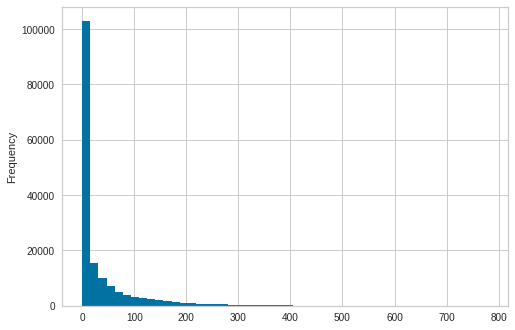

In [ ]:
df_proba_questions_words_test.stack().plot.hist(bins=50)

On calcule le taux de tags prédits (nombre de 1 dans y_test)

In [ ]:
# Pourcentage de tags réel dans le test set
np.count_nonzero(y_test==1)/(np.count_nonzero(y_test==0)+np.count_nonzero(y_test==1))

0.031503030303030304

On calcule le seuil a partir duquel on considère le tags prédit pour la question. Pour ce faire, on calcule le quantile correspondant à 1 - nombre de 1 dans y_test.

In [ ]:
df_proba_questions_words_test.stack().quantile(.965)

206.41699145833292

Toutes les valeurs en dessous du seuil sont passées à 0, et celles supèrieures à 1:

In [ ]:
pred_lda = df_proba_questions_words_test.to_numpy()

In [ ]:
pred_lda[pred_lda < 206] = 0
pred_lda[pred_lda >= 206] = 1

On peut maintenant comparer ces prédictions avec le réel test set (ainsi qu'avec la précision d'autres modèles).

In [ ]:
accuracy_score(y_test, pred_lda)

0.03484848484848485

## Comparaison avec un modèle supervisé

### TF-IDF

In [ ]:
tfidf_vectorizer = TfidfVectorizer(
    max_features=4000
    )

nb. limiter le nombre de features ne fait pas perdre en performance.

In [ ]:
X_train_transformed = tfidf_vectorizer.fit_transform(X_train)

In [ ]:
X_test_transformed = tfidf_vectorizer.transform(X_test)

### Modèle MultiOutputClassifier 

In [ ]:
clf = MultiOutputClassifier(LogisticRegression(class_weight=None)).fit(X_train_transformed, y_train)

In [ ]:
y_pred = clf.predict(X_test_transformed)

In [ ]:
accuracy_score(y_test, y_pred)

0.19303030303030302

metrics:
https://mmuratarat.github.io/2020-01-25/multilabel_classification_metrics

In [ ]:
hamming_loss(y_test, y_pred)

0.026854545454545454

In [ ]:
hamming_loss(pred_lda, y_pred)

0.03729090909090909

## Rejet de la LDA detournée comme methode prédictive


A ce stade, ***je choisi de ne pas utiliser la methode de prédiction dérivée de la LDA*** ci-dessus, et ce pour plusieurs raisons:

- L'entrainement est long, nous avons été obligé de l'effectuer sur un **set de données restreint**.

- **On peut simplement comparer le nombre de tags que notre LDA peut prédire avec ceux que nous souhaitons prédire.** **LDA ne ressort en effet que 35 des 50 tags les plus communs que nous souhaitons prédire**.  Cela est lié aupréprocessing nécessaire des données en entrée. Le traitement du code présent dans les questions (tokenization et suppression de nombreux charactères non-alphanumériques) nous oblige à dénaturer certains tags potentiels (eg. c++, .net, etc). D'autres tags ne sont probablement quasiment pas évoqués directement dans les questions SO, et ne ressortiront donc pas dans les mots suggèrés par la LDA. **Cette comparaison (de principe) entre la LDA et n'importe quelle méthode de classification supervisée me semble suffisante pour écarter la LDA**.

- De plus, l'**accuracy calculée est médiocre (2%)**, alors qu'une simple regression logistique par label performe à 14%. Sur plus de données, il est hautement improbable que des methodes plus avancées d'embedding et des modèles plus avancés performent moins bien que la LDA detournée.

- Effectuer des prédictions s'avère compliqué: les valeurs de la Matrice Mots x Questions ne sont pas des probabilités. Il serait hasardeux de déterminer un seuil au dessus duquel on considèrerait le tag comme prédit, ou encore de considérer les X tags ayant les valeurs la plus hautes pour chaque question comme les tags prédits. C'est une des raison pour lesquelles **la LDA n'est simplement pas pensée, ni utilisée en pratique dans l'industrie pour effectuer de l'apprentissage supervisé**.




# Apprentissage Supervisé

## TF-IDF + Régression Logistique en MultiOutputClassifier 
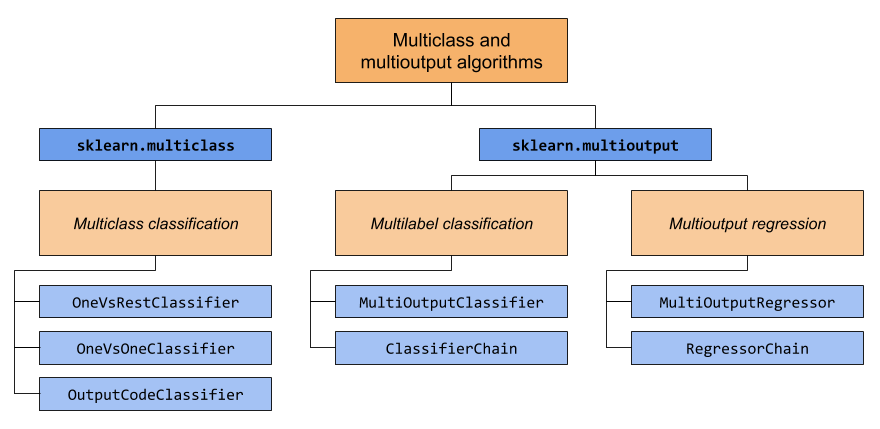

### Train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_cleaned.cleaned_Text, mlb_tags, test_size=0.33, random_state=42)

In [ ]:
X_train

22840    url rewrite css js image loadingi follow rule ...
27680    truncate table within transactioncan sql trunc...
50112    vba save file utf without bomit probably sthg ...
0        get directory listing chow scan directory fold...
11616    make parent wait child process finishi hope so...
                               ...                        
11284    set focus textbox wpf view modeli view check c...
44732    fix miss cross origin resource sharing cor res...
38158    save stdout subprocess popen file plus write s...
860      nsstring convert pure alphabet e remove accent...
15795    difference excels form controls activex contro...
Name: cleaned_Text, Length: 36012, dtype: object

### TF-IDF

In [ ]:
tfidf_vectorizer = TfidfVectorizer(
    max_features=2000
    )

nb. limiter le nombre de features ne fait pas perdre en performance mais accélère grandement les temps d'entrainement des modèles.

### Modèle MultiOutputClassifier

In [ ]:
clf = MultiOutputClassifier(LogisticRegression(class_weight=None))

### Pipeline Scikit-Learn

In [ ]:
pipe = Pipeline([('TF-IDF', tfidf_vectorizer), ('MOC_Reg_log', clf)])

pipe.fit(X_train, y_train)

### Evaluation

In [ ]:
# Predictions du test set
MOC_pred = pipe.predict(X_test)

In [ ]:
accuracy_score(y_test, MOC_pred)

0.2936069455406472

In [ ]:
jaccard_score(y_test, MOC_pred, average="macro")

0.30636360760621745

In [ ]:
hamming_loss(y_test, MOC_pred)

0.02237907317623182

### Prédictions pour une question stackoverflow

Test du pipeline sklearn qui sera utilisé dans l'API REST.

Test de mises en forme des prédictions outputées pour chaque endpoint de l'API.

In [ ]:
# Exemple de titre
df.Title[26565]

'Android BLE API: GATT Notification not received'

In [ ]:
# Exemple de corps
df.Body[26565]

'<p>Device used for testing: Nexus 4, Android 4.3</p>\n\n<p>Connection is working fine but the <code>onCharacteristicChanged</code>Method of my callback is never called. However I am registering for notifications using <code>setCharacteristicNotification(char, true)</code> inside <code>onServicesDiscovered</code> and that function even returns true.</p>\n\n<p>Device log (there are actually <em>no</em> messages at all when notifications <em>should</em> appear / are sent via the Bluetooth device):</p>\n\n<pre><code>07-28 18:15:06.936  16777-16809/de.ffuf.leica.sketch D/BluetoothGatt: setCharacteristicNotification() - uuid: 3ab10101-f831-4395-b29d-570977d5bf94 enable: true\n07-28 18:15:06.936    4372-7645/com.android.bluetooth D/BtGatt.GattService: registerForNotification() - address=C9:79:25:34:19:6C enable: true\n07-28 18:15:06.936    4372-7645/com.android.bluetooth D/BtGatt.btif: btif_gattc_reg_for_notification\n07-28 18:15:06.946    4372-7645/com.android.bluetooth D/BtGatt.btif: btgat

In [ ]:
# Attribution des classes
classes = mlb.classes_

#### Prédiction des tags (Premier endpoint)

In [ ]:
# Matrice des prédictions pour l'observation
pipe.predict([X_test[49994]])

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        0, 0, 0, 0, 0, 0]])

In [ ]:
# Mise en forme intermédiaire
zip_tags = zip(classes, pipe.predict([X_test[49994]])[0])
predicted_tags = dict(zip_tags)

# Check
print(predicted_tags)

{'.net': 0, 'ajax': 0, 'algorithm': 0, 'android': 0, 'arrays': 0, 'asp.net': 0, 'asp.net-mvc': 0, 'bash': 0, 'c': 0, 'c#': 1, 'c++': 0, 'c++11': 0, 'cocoa-touch': 0, 'css': 0, 'database': 0, 'django': 0, 'git': 0, 'html': 0, 'image': 0, 'ios': 0, 'iphone': 0, 'java': 0, 'javascript': 0, 'jquery': 0, 'json': 0, 'linux': 0, 'macos': 0, 'multithreading': 0, 'mysql': 0, 'node.js': 0, 'numpy': 0, 'objective-c': 0, 'pandas': 0, 'performance': 0, 'php': 0, 'python': 0, 'python-3.x': 0, 'r': 0, 'ruby': 0, 'ruby-on-rails': 0, 'security': 0, 'spring': 0, 'sql': 1, 'sql-server': 1, 'string': 0, 'swift': 0, 'unit-testing': 0, 'windows': 0, 'wpf': 0, 'xcode': 0}


In [ ]:
# Mise en forme de liste dans un Json pour API
list_predicted = [k for k,v in predicted_tags.items() if v == 1]

predicted_tags = { 'predicted_tags' : list_predicted}

In [ ]:
# Check
predicted_tags

{'predicted_tags': ['c#', 'sql', 'sql-server']}

#### Prédiction des probabilités pour chaque tag (Second endpoint)

In [ ]:
# Matrice de probabilités de chaque tag pour l'observation
np.vstack(pipe.predict_proba([X_test[26565]]))[:,1]

array([0.00378176, 0.00277627, 0.00173288, 0.98944559, 0.00126323,
       0.00452877, 0.0028876 , 0.00103045, 0.00515356, 0.00772104,
       0.00305546, 0.00156703, 0.00864638, 0.00185872, 0.00146333,
       0.00360468, 0.0012927 , 0.00348241, 0.00187409, 0.33851697,
       0.03019943, 0.04877279, 0.01493798, 0.00349388, 0.00285701,
       0.00431654, 0.01038118, 0.00455301, 0.00234623, 0.00525575,
       0.00108025, 0.03278205, 0.00116317, 0.00485462, 0.00648307,
       0.00418583, 0.002002  , 0.00241828, 0.00273599, 0.00366469,
       0.0042521 , 0.00367788, 0.00147738, 0.0024181 , 0.00208291,
       0.00990834, 0.00352631, 0.0049338 , 0.0016109 , 0.00617595])

In [ ]:
# Mise en forme Json pour API
zip_proba = zip(classes, np.vstack(pipe.predict_proba([X_test[26565]]))[:,1])

predicted_proba = dict(zip_proba)

print(predicted_proba)

{'.net': 0.0037817566801795453, 'ajax': 0.0027762684976640837, 'algorithm': 0.001732882152772973, 'android': 0.989445594050223, 'arrays': 0.00126323141737394, 'asp.net': 0.004528774437757296, 'asp.net-mvc': 0.002887603360067307, 'bash': 0.0010304518534945046, 'c': 0.005153557470413229, 'c#': 0.007721038133431492, 'c++': 0.0030554604976160814, 'c++11': 0.0015670275780673597, 'cocoa-touch': 0.00864638465676039, 'css': 0.0018587233485162055, 'database': 0.0014633320015124398, 'django': 0.0036046817938616958, 'git': 0.0012926983262132267, 'html': 0.0034824093325105834, 'image': 0.0018740859149038733, 'ios': 0.33851697168994327, 'iphone': 0.030199429064845497, 'java': 0.048772785670937256, 'javascript': 0.014937983165009182, 'jquery': 0.003493884654133895, 'json': 0.0028570089868041907, 'linux': 0.004316539547766387, 'macos': 0.010381183646570594, 'multithreading': 0.004553007707693909, 'mysql': 0.002346225582203941, 'node.js': 0.00525574712096555, 'numpy': 0.0010802524228699978, 'objective

### Pickles

On pickle le modèle et le pipeline avec le tf-IDF pour l'utiliser dans notre API.

In [ ]:
import pickle

#### Pipeline scikit learn

In [ ]:
# Sauvegarde du modèle
pkl_filename = 'model.pkl'
with open('drive/MyDrive/PStackOverflow/' + pkl_filename, 'wb') as f:
    pickle.dump(pipe, f)

#### Classes du MultiLabelBinarizer
On pickle également les classes pour notre API.

In [ ]:
# Sauvegarde des classes
classes = mlb.classes_

pkl_filename = 'classes.pkl'
with open('drive/MyDrive/PStackOverflow/' + pkl_filename, 'wb') as f:
    pickle.dump(classes, f)

## Nettoyage du texte pour embeddings

Le code utilisé pour les 3 embeddings ci-dessous (preprocessing, calcul des embeddings) vient en grande partie du notebook suivant: 
https://s3.eu-west-1.amazonaws.com/course.oc-static.com/projects/Data_Scientist_P6/Exemple_Tweets_Feature-extraction_Sentence+Embedding_V1.1.ipynb

In [ ]:
# Import des librairies nécessaires
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import time
from sklearn import cluster, metrics
from sklearn import manifold, decomposition
import logging

logging.disable(logging.WARNING) # disable WARNING, INFO and DEBUG logging everywhere


/usr/local/lib/python3.7/dist-packages/nltk/decorators.py:70: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  formatvalue=lambda value: "")[1:-1]
/usr/local/lib/python3.7/dist-packages/scipy/io/matlab/mio5.py:98: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from .mio5_utils import VarReader5


On retire les tags HTML avec la fonction utilisée dans le premier notebook du projet:

In [ ]:
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    return stripped_text

In [ ]:
# Application de la fonction de retrait du html
df_clean = pd.DataFrame()

df_clean["Text"] = df["Text"].apply(lambda x : strip_html_tags(x))

On détermine les fonctions de préprocessings nécessaires à chaque embedding:

In [ ]:
# Tokenizer
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.tokenize import sent_tokenize, word_tokenize


def tokenizer_fct(sentence) :
    # print(sentence)
    sentence_clean = sentence.replace('-', ' ').replace('+', ' ').replace('/', ' ').replace('#', ' ')
    word_tokens = word_tokenize(sentence_clean)
    return word_tokens

# Stop words
from nltk.corpus import stopwords
stop_w = list(set(stopwords.words('english'))) + ['[', ']', ',', '.', ':', '?', '(', ')']

def stop_word_filter_fct(list_words) :
    filtered_w = [w for w in list_words if not w in stop_w]
    filtered_w2 = [w for w in filtered_w if len(w) > 2]
    return filtered_w2

# lower case et alpha
def lower_start_fct(list_words) :
    lw = [w.lower() for w in list_words if (not w.startswith("@")) 
    #                                   and (not w.startswith("#"))
                                       and (not w.startswith("http"))]
    return lw

# Lemmatizer (base d'un mot)
from nltk.stem import WordNetLemmatizer

def lemma_fct(list_words) :
    lemmatizer = WordNetLemmatizer()
    lem_w = [lemmatizer.lemmatize(w) for w in list_words]
    return lem_w

# Fonction de préparation du texte pour le bag of words (Countvectorizer et Tf_idf, Word2Vec)
def transform_bow_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    # lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lw)
    return transf_desc_text

# Fonction de préparation du texte pour le bag of words avec lemmatization
def transform_bow_lem_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lem_w)
    return transf_desc_text

# Fonction de préparation du texte pour le Deep learning (USE et BERT)
def transform_dl_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
#    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(word_tokens)
    # lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lw)
    return transf_desc_text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


On applique les différents preprocessings nécessaires:

In [ ]:
# Application des preprocessing propres à chaque methode d'embedding
df_clean['sentence_bow'] = df_cleaned["Text"].apply(lambda x : transform_bow_fct(x))

In [ ]:
df_clean['sentence_bow_lem'] = df_cleaned["Text"].apply(lambda x : transform_bow_lem_fct(x))

In [ ]:
df_clean['sentence_dl'] = df_cleaned["Text"].apply(lambda x : transform_dl_fct(x))
df_clean.shape

(53750, 4)

## Détermination de la maxlen

la maxlen est le nombre de tokens pris en compte par observation (eg. maxlen = 50, les embeddings sont fait sur les 50 premiers token de chaque observation).

In [ ]:
# Nombre tokens par question
word_number = [len(sentence.split()) for sentence in df_clean['sentence_dl']]

(array([3.4255e+04, 1.3625e+04, 3.5460e+03, 1.2370e+03, 5.3800e+02,
        2.5200e+02, 1.1500e+02, 6.6000e+01, 4.6000e+01, 2.8000e+01,
        1.5000e+01, 9.0000e+00, 6.0000e+00, 3.0000e+00, 2.0000e+00,
        1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
        1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  15.        ,  210.06666667,  405.13333333,  600.2       ,
         795.26666667,  990.33333333, 1185.4       , 1380.46666667,
        1575.53333333, 1770.6       , 1965.66666667, 2160.73333333,
        2355.8       , 2550.86666667, 2745.93333333, 2941.        ,
        3136.06666667, 3331.13333333, 3526.2       , 3721.26666667,
        3916.33333333, 4111.4       , 4306.46666667, 4501.53333333,
        4696.6       , 4891.66666667, 5086.73333333, 5281.8       ,
        5476.86666667, 5671.93333333, 5867.        ]),
 <a list of 30 Patch objects>)

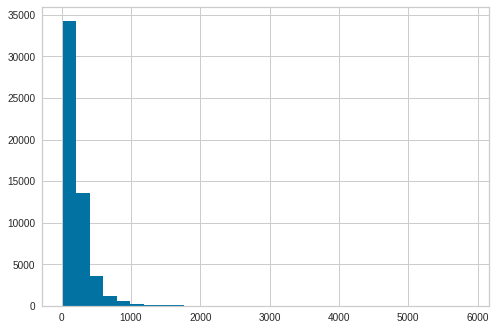

In [ ]:
# Hist nombre tokens
from matplotlib import pyplot as plt
plt.hist(word_number, bins=30)

Après plusieurs essais, **150** semble être un bon compromis couvrant la majorité des observations tout en gardant des temps de calculs raisonables.

## Word2Vec + Régression Logistique en MultiOutputClassifier 

In [ ]:
# Instalation de TS GPU pour accélerer les calculs sur le GPU de Google Colab
!pip install tensorflow-gpu

In [ ]:
# Import des librairies nécessaires
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import gensim

In [ ]:
# Check d'une sentence preprocessée
df_clean.sentence_bow_lem[53749]

"unable load class androidcomponentsextension upgrading android gradle plugin 7.1 recently downloaded href= developer.android.com studio release bumblebee rel= noreferrer android studio bumblebee helpfully asked whether wanted upgrade android gradle plugin 7.1.0 version shipped alongside android studio bumblebee. after upgrading get build error pre pre and looking file see pre pre which mean n't run app need downgrade agp 7.0 get thing working how fix upgrade android gradle plugin 7.1.0"

### Création du modèle Word2Vec

In [ ]:

df_clean['sentence_bow_lem'] = df_clean['sentence_bow_lem'].fillna('').astype(str)

In [ ]:
w2v_size=300
w2v_window=5
w2v_min_count=1
w2v_epochs=50
maxlen = 150    # adapt to length of sentences

sentences =  df_clean['sentence_bow_lem'].to_list() # df_cleaned.cleaned_Text.to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

In [ ]:
# Gère les différents threads
import multiprocessing

In [ ]:
# Création et entraînement du modèle Word2Vec

print("Build & train Word2Vec model ...")
w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, window=w2v_window,
                                                vector_size=w2v_size,
                                                seed=42,
#                                                workers=1)
                                                workers=multiprocessing.cpu_count())
w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

Build & train Word2Vec model ...
Vocabulary size: 80004
Word2Vec trained


In [ ]:
# Préparation des sentences (tokenization)

print("Fit Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                                                     maxlen=maxlen,
                                                     padding='post') 
                                                   
num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)

Fit Tokenizer ...
Number of unique words: 80005


### Création de la matrice d'embedding

In [ ]:
# Création de la matrice d'embedding

print("Create Embedding matrix ...")
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i=0
j=0
    
for word, idx in word_index.items():
    i +=1
    if word in w2v_words:
        j +=1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]
            
word_rate = np.round(j/i,4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (80005, 300)


### Création du modèle d'embedding

In [ ]:
# Création du modèle

input=Input(shape=(len(x_sentences),maxlen),dtype='float64')
word_input=Input(shape=(maxlen,),dtype='float64')  
word_embedding=Embedding(input_dim=vocab_size,
                         output_dim=w2v_size,
                         weights = [embedding_matrix],
                         input_length=maxlen)(word_input)
word_vec=GlobalAveragePooling1D()(word_embedding)  # représente la phrase comme la moyenne des vecteurs qui reprst chaque mot
embed_model = Model([word_input],word_vec)

embed_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150)]             0         
                                                                 
 embedding (Embedding)       (None, 150, 300)          24001500  
                                                                 
 global_average_pooling1d (G  (None, 300)              0         
 lobalAveragePooling1D)                                          
                                                                 
Total params: 24,001,500
Trainable params: 24,001,500
Non-trainable params: 0
_________________________________________________________________





### Exécution du modèle et Obtention des embeddings

In [ ]:
embeddings = embed_model.predict(x_sentences)
embeddings.shape

(53750, 300)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x_sentences, mlb_tags, test_size=0.33, random_state=42)

In [ ]:
X_train = embed_model.predict(X_train)

In [ ]:
X_test = embed_model.predict(X_test)

### Modèle MultiOutputClassifier

On entraine un MultiOutputClassifier avec régressions logistiques sur les embeddings:

In [ ]:
# Entrainement du modèle
clf_Word2Vec = MultiOutputClassifier(LogisticRegression(class_weight=None)).fit(X_train, y_train)

### Evaluation

In [ ]:
Word2Vec_pred = clf_Word2Vec.predict(X_test)

In [ ]:
accuracy_score(y_test, Word2Vec_pred)

0.2778780020295411

In [ ]:
jaccard_score(y_test, Word2Vec_pred, average="macro")

0.2913225455280536

In [ ]:
hamming_loss(y_test, Word2Vec_pred)

0.023699402412898862

## Cleaning de la RAM

In [ ]:
del df
del visualizer
del tag_occurences
del tag_df
del texts
del texts_test
del panel
del dataset
del common_dictionary
del corpus
del M_questions_topics_train
del M_questions_topics_test
del M_topics_words
del M_proba_questions_words_train
del M_proba_questions_words_test
del df_proba_questions_words_test
del X_train_transformed
del X_test_transformed
del model_vectors
del w2v_words
del x_sentences
del embeddings

## BERT + Régression Logistique en MultiOutputClassifier 

On répète la même démarche en créant les embeddings avec BERT sur lesquels nous allons entrainer un MultiOutputClassifier  en reg log.

In [ ]:
# Imports
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model



In [ ]:
# Installations
!pip install transformers

In [ ]:
!pip install sentencepiece

In [ ]:
!pip install sacremoses

In [ ]:
# Imports
import os
import transformers
from transformers import *

os.environ["TF_KERAS"]='1'

### Préparation des sentences et des features

In [ ]:
# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True, 
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
    
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0], 
                             bert_inp['token_type_ids'][0], 
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    return input_ids, token_type_ids, attention_mask, bert_inp_tot
    

# Fonction de création des features
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size], 
                                                                      bert_tokenizer, max_length)
        
        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids, 
                                 "input_mask" : attention_mask, 
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']
             
        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))
    
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)
    
    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2)
     
    return features_bert, last_hidden_states_tot

### BERT hub Tensorflow

In [ ]:
!pip install tensorflow_text

### Determination du modèle BERT: small BERT

Je choisi d'utiliser un BERT préentrainé avec moins de paramètres, Google Colab et ma machine n'ayant pas assez de RAM pour utiliser les modèles plus grands.

In [ ]:
import tensorflow_hub as hub
import tensorflow_text 

# Guide sur le Tensorflow hub : https://www.tensorflow.org/text/tutorials/classify_text_with_bert
model_url = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/2'
bert_layer = hub.KerasLayer(model_url, trainable=False)

### Obtention des embeddings

In [ ]:
sentences = df_clean['sentence_dl'].to_list()

In [ ]:

max_length = 150
batch_size = 25
# 128 dimensions
# Small Bert :
# 4 Layers (L)
# 128 Hidden Layer size (H)
# 2 Attention Heads (A)


model_type = 'bert-base-uncased'
model = bert_layer

features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_length, batch_size, mode='TFhub')

temps traitement :  3871.0


In [ ]:
features_bert.shape

(53750, 128)

### Modèle MultiOutputClassifier


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features_bert, mlb_tags, test_size=0.33, random_state=42)

In [ ]:
# entrainement du modèle
clf_BERT = MultiOutputClassifier(LogisticRegression(class_weight=None)).fit(X_train, y_train)

### Evaluation

In [ ]:
BERT_pred = clf_BERT.predict(X_test)

In [ ]:
accuracy_score(y_test, BERT_pred)

0.13868530837749465

In [ ]:
jaccard_score(y_test, BERT_pred, average="macro")

0.083053470854617

In [ ]:
hamming_loss(y_test, BERT_pred)

0.029801555981508625

## USE + Régression Logistique en MultiOutputClassifier

In [ ]:
# Imports
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model


import transformers
from transformers import *

os.environ["TF_KERAS"]='1'

In [ ]:
# Check GPU
print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.8.0
2.8.0
Num GPUs Available:  0
True


In [ ]:
# Load USE
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

### Obtention des embeddings

In [ ]:
def feature_USE_fct(sentences, b_size) :
    batch_size = b_size
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    time2 = np.round(time.time() - time1,0)
    return features

In [ ]:
# Set batchsize
batch_size = 10
#512 dimensions

sentences = df_clean['sentence_dl'].to_list()

In [ ]:
# Calcul des embeddings
features_USE = feature_USE_fct(sentences, batch_size)

### Modèle MultiOutputClassifier

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features_USE, mlb_tags, test_size=0.33, random_state=42)

In [ ]:
# Entraine le modèle
clf_USE = MultiOutputClassifier(LogisticRegression(class_weight=None)).fit(X_train, y_train)

### Evaluation

In [ ]:
USE_pred = clf_USE.predict(X_test)

In [ ]:
accuracy_score(y_test, USE_pred)

0.33261923553951966

In [ ]:
hamming_loss(y_test, USE_pred)

0.02054008343668959

In [ ]:
jaccard_score(y_test, USE_pred, average="macro")

0.35467268056299056

# Conclusion: TF-IDF modèle retenu

Les embeddings W2V et BERT utilisés pour l'entrainement d'un MultiOutputClassifier avec Reglog offrent des résultats moins satisfaisants que USE et TF-IDF.

USE suivi de TF-IDF apportent les meilleurs résultats.

Bien que USE offre des résultats meilleurs, **je choisi de retenir TF-IDF** pour les raisons suivantes:
- methode beaucoup plus simple et rapide
- beaucoup plus léger pour utiliser dans une API: la RAM étant limitée avec Heroku (utilisé pour deployer l'API de prédiction), USE serait trop imposant.

**nb. l'entrainement d'un modèle de deep learning sur Word2Vec, BERT et USE offriraient probablement de bien meilleurs résultats que le MultiOutputClassifier** 